In [168]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

## Perform some Data Augmentation on the ```balanced_train``` dataset

In [169]:
# Load balanced_train_df.parquet
balanced_df = pd.read_parquet("balanced_train_df.parquet")

### Paths to training, validation and testing images (pending to discuss)

In [170]:
train_img_dir = "../Proj/train_img_dir" # the same as the ones at the end of dataprocessing.ipynb
valid_img_dir = "../Proj/valid_img_dir"
test_img_dir = "../Proj/airbus-ship-detection/test_v2" # '/Downloads/airbus-ship-detection/test_v2'

# Get train/validation Image IDs
train_ids = balanced_df[balanced_df['split'] == 'train']['ImageId'].to_list()
valid_ids = balanced_df[balanced_df['split'] == 'valid']['ImageId'].to_list()
test_ids = [img for img in os.listdir(test_img_dir)]

### Dataset Class for saving the images

In [174]:
class ShipDataset(Dataset):
    def __init__(self, split='train', transform=None):
        """
        Args:
            split (str): images for training, validation or testing
            transform (albumentations.Compose): augmentation pipeline
        """
        if split=='train':
            self.image_dir = train_img_dir
            self.image_ids = train_ids
            self.has_masks = True
        elif split=='valid':
            self.image_dir = valid_img_dir
            self.image_ids = valid_ids
            self.has_masks = True
        elif split=='test':
            self.image_dir = test_img_dir
            self.image_ids = test_ids
            self.has_masks = False

        self.transform = transform

        if self.has_masks:
            # Preload mask data
            self.masks_df = pd.read_csv("masks_subset.csv")
            self.masks_dict = self.masks_df.groupby('ImageId')['EncodedPixels'].apply(list).to_dict()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, image_id)
        image = np.array(Image.open(img_path).convert("RGB"))

        # Get mask from dictionary
        if self.has_masks:
            rle_list = self.masks_dict.get(image_id, [])
            mask = masks_as_image(rle_list)
        else:
            mask = None

        # Apply transform if given
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'] if mask is not None else None

        return image, mask

### Compute mean and std of the train dataset

In [18]:
from tqdm import tqdm

def compute_mean_std(image_dir):
    """
    Compute mean and std pixel values for every channel
    This is costly, so it is recommended to run only once, and save the values for later (already below)
    """
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))]

    n_pixels = 0
    sum_rgb = np.zeros(3, dtype=np.float64)
    sum_rgb_sq = np.zeros(3, dtype=np.float64)

    for fname in tqdm(image_files):
        img = Image.open(os.path.join(image_dir, fname)).convert("RGB")
        arr = np.array(img, dtype=np.float32) / 255.0  # scale to [0,1]

        arr = arr.reshape(-1, 3)

        sum_rgb += arr.sum(axis=0)
        sum_rgb_sq += (arr ** 2).sum(axis=0)
        n_pixels += arr.shape[0]

    mean = sum_rgb / n_pixels
    std = np.sqrt(sum_rgb_sq / n_pixels - mean**2)

    return mean, std

mean, std = compute_mean_std("../Proj/train_img_dir")

In [20]:
print(mean, std)

(0.2118874, 0.3067525, 0.31743594) (0.20147397, 0.1720894, 0.15324762)


### Here we perform the data augmentation methods.

In [175]:
import albumentations as A
import torchvision.transforms as T
from albumentations.pytorch import ToTensorV2

mean = (0.2118874, 0.3067525, 0.31743594)
std = (0.20147397, 0.1720894, 0.15324762)

std_inv = 1 / (np.array(std) + 1e-7)
std_inv = np.array(std_inv)

unnormalize = T.Normalize(mean=(-np.array(mean)*std_inv), std=std_inv)


transforms_train = A.Compose([
    A.RandomResizedCrop(size=(640,640)),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.GaussianBlur(sigma_limit=(0.2, 2.0)),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    A.VerticalFlip(p=0.5),
    A.Resize(height=640, width=640),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
], additional_targets={'mask': 'mask'}) # this ensures the mask is transformed the same way as the image

transforms_val = A.Compose([
    A.Resize(height=640, width=640),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
], additional_targets={'mask': 'mask'})

### Plotting example

In [185]:
dataset_plot = ShipDataset()

Processing image index 4200...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1922263e-07..0.90196115].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1922263e-07..0.75686306].


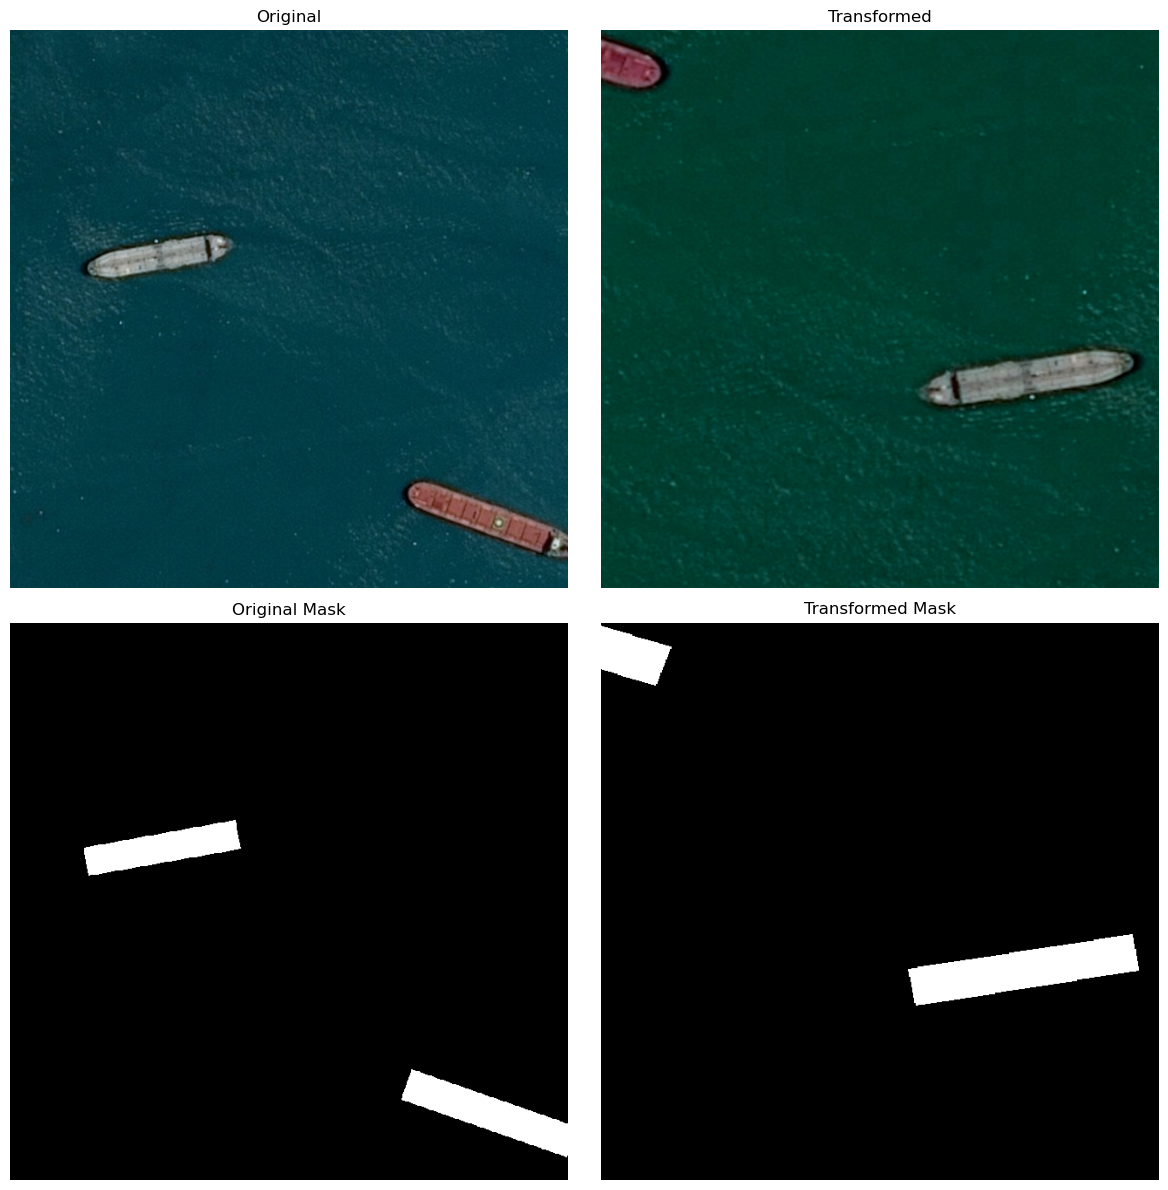

In [193]:
import torch
import matplotlib.pyplot as plt
from helpers import masks_as_image

def visualize_ship_sample(dataset, idx):
    """
    Visualize a single ship dataset sample:
    Left: original image + mask
    Right: transformed image + mask
    """

    print(f"Processing image index {idx}...")
    img, mask = dataset[idx]

    # --- Load Transformed Image & Mask ---
    aug_val = transforms_val(image=img, mask=mask)
    val_img = aug_val['image']       # tensor C,H,W si ToTensorV2, numpy H,W,C si no
    val_mask = aug_val['mask']

    aug_train = transforms_train(image=img, mask=mask)
    tr_img = aug_train['image']
    tr_mask = aug_train['mask']

    # --- Plot ---
    fig, axes = plt.subplots(2, 2, figsize=(12,12))

    axes[0,0].imshow(unnormalize(val_img).permute(1,2,0))
    axes[0,0].axis('off')
    axes[0,0].set_title("Original")

    axes[0,1].imshow(unnormalize(tr_img).permute(1,2,0))
    axes[0,1].axis('off')
    axes[0,1].set_title("Transformed")

    axes[1,0].imshow(val_mask, cmap='gray', vmin=0, vmax=1)
    axes[1,0].axis('off')
    axes[1,0].set_title("Original Mask")

    axes[1,1].imshow(tr_mask, cmap='gray', vmin=0, vmax=1)
    axes[1,1].axis('off')
    axes[1,1].set_title("Transformed Mask")

    plt.tight_layout()
    plt.show()

# Plotting example
visualize_ship_sample(dataset_plot, idx=4200)

### Integrate augmentation pipeline into ShipDataset class

In [194]:
# Create datasets
train_dataset = ShipDataset(
    split='train',
    transform=transforms_train
)

valid_dataset = ShipDataset(
    split='valid',
    transform=transforms_val
)

test_dataset = ShipDataset(
    split='test',
    transform=transforms_val
)

print(f"Train: {len(train_dataset)}, Valid: {len(valid_dataset)}, Test: {len(test_dataset)}")

Train: 10230, Valid: 2558, Test: 15606


In [195]:
import pickle

# Save datasets
with open("datasets.pkl", "wb") as f:
    pickle.dump({
        "train_dataset": train_dataset,
        "valid_dataset": valid_dataset,
        "test_dataset": test_dataset
    }, f)

### NEXT THING TO DO:
1. Create new notebook: ```model_training_testing.ipynb``` (or smth similar)
2. In the first cell, read the datasets (final output of this notebook) --> See cell below
3. Wrap the 3 datasets in a DataLoader object, for batching (optimal way of training NNs) --> See cell below
4. Start deploying the model! Training (using validation) and final testing!

In [ ]:
# Step 2:
import pickle

with open("datasets.pkl", "rb") as f:
    train_dataset, valid_dataset, test_dataset = pickle.load(f)


# Step 3:
from torch.utils.data import DataLoader

# Just an example of how it could be done:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8)
val_loader   = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=8)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)
